# Numerical Exercises 07

Before running this notebbok, you need to execute the following scripts to produce the results:
- `./ex07.1.sh`
- `./ex07.2.sh`
- `./ex07.3.sh`

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.style as style 
style.use('tableau-colorblind10')

# Molecular dynamics
## Simulation in the canonical ensemble using MCMC methods

In these exercises we study the molecular dynamics of a system using a Metropolis algorithm to sample the Boltzmann probability distribution

$$
p(\vec{r}_1,\dots,\vec{r}_N) = \frac{e^{-\beta \ U(\vec{r}_1,\dots,\vec{r}_N)}}{Z},
$$

in the canonical ensemble $NVT$. We use a uniform trial transition probability, tuning its width $\Delta$ to obtain an acceptance probability of $50 \%$. 

The thermodynamics quantities of interest are energy and pressure, which are computed through the thermodynamics relations and improved by **tail corrections** (a spherical cutoff for the intermolecular potential at distance $r_C$).

At the end, we estimate the **radial distribution function** $g^{(2)}(\vec r_i, \vec r_j)$, defined as follow:

$$
g_N^{(2)}=\frac{\rho_N^{(2)}(\vec r_1, \vec r_2)}{\rho_N^{(1)}(\vec r_1)\rho_N^{(1)}(\vec r_2)},
$$

in the range $r=[0,\,L/2]$. The idea to compute it is:

- divide the range $r=[0,\,L/2]$ into sub-ranges (each wide $dr$)
- count at every MC steps how many particles are within a distance $r+dr$
- normalize by the quantity $\rho N \Delta V(r)$
- blocking method in the end

Then we compare the results with the one obtained using the Verlet algorithm to evolve the same system in the microcanonical ensemble $NVE$.

For both the ensembles the system is made of $N = 108$ particles, in a fixed volume $V$ with periodic boundary conditions and fixed energy/temperature for the microcanonical/canonical ensemble. The parameters for each state of matter are:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

# Exercise 07.1

The goal of this exercise is to select a proper block length $L$, which will later be used for the blocking method. To do so we first equilibrate the system with $M = 10000$ steps and then run a simulation of $M = 5*10^5$ steps, in which we measure the instantaneous values of $E$ and $P$ for each state of matter. The final outputs of the simulation are then used to calculate the autocorrelation functions in order to properly check at which time each step is uncorrelated from the previous one, and so deciding the most appropriate block length.

The equilibration results are below plotted and show again how this phase is important to reach a stable configuration (even if in this case the pressure is a bit more volatile than the energy). The graphs are rescaled to better osserve the three state of matter in the same plot.

In [2]:
nburn = 10000  #step for equilibration
nstep = 50000  #step for simulation
nstp=(3000,3000)   #graphs will represent nstp[0] first and nstp[1] last steps
lab_state=['solid','liquid','gas']; title_burn=('First','Last')
title=['Potential energy','Pressure']

def graph_burn(meas, ifburn):   #meas is "energy" or "pres"
    label=lab_state.copy(); tit=title.copy()
    if ifburn:
        name='results_eq'; tit=', equilibration'
        head=(1,nburn-nstp[1]); max_r=(nstp[0],nburn)  #genfromtxt parameters
    else:
        name='results'; tit=', simulation'
        head=(1,nstep-nstp[1]); max_r=(nstp[0],nstep)
    
    pl.figure(figsize=(15,5))
    for i in range(2):
        obs_s=np.genfromtxt('build/ex07.1/solid/'+name+'/instant_'+meas+'.dat',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_l=np.genfromtxt('build/ex07.1/liquid/'+name+'/instant_'+meas+'.dat',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_g=np.genfromtxt('build/ex07.1/gas/'+name+'/instant_'+meas+'.dat',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs=(obs_s,obs_l,obs_g)
        p_rescale=(20.,12.,1.);    #scale factor for visually more clear graphs
        y_lab='$U$'
        if meas=="pres":
            for k in range(3): obs[k]['u']/=p_rescale[k]; label[k]=lab_state[k]+' (/'+str(int(p_rescale[k]))+')'
            y_lab='$P$'

        pl.subplot(1,2,i+1)
        for j in range(3): pl.plot(obs[j]['x'],obs[j]['u'],label=label[j])
        if meas=="epot": pl.ylim(-9,0)
        elif meas=="pres": pl.ylim(-0.4,0.7)
        pl.legend(loc='best')
        pl.xlabel('$N_{stp}$')
        if i==0: pl.ylabel(y_lab,labelpad=15)
        pl.title(title_burn[i]+' '+str(nstp[i])+' points')
        pl.grid(True)
    
    if meas=="epot": pl.suptitle(title[0]+tit)
    elif meas=="pres": pl.suptitle(title[1]+tit)
    pl.show()

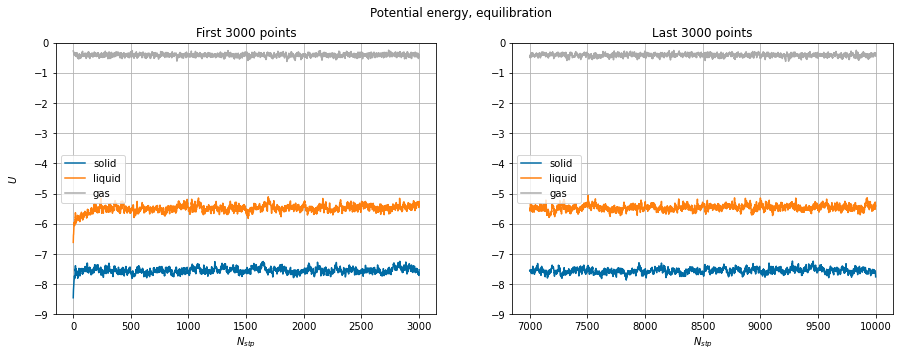

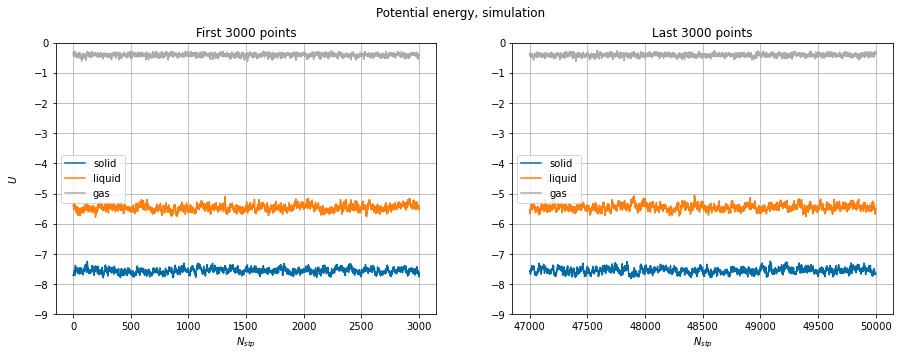

In [3]:
graph_burn("epot",True)
graph_burn("epot",False)

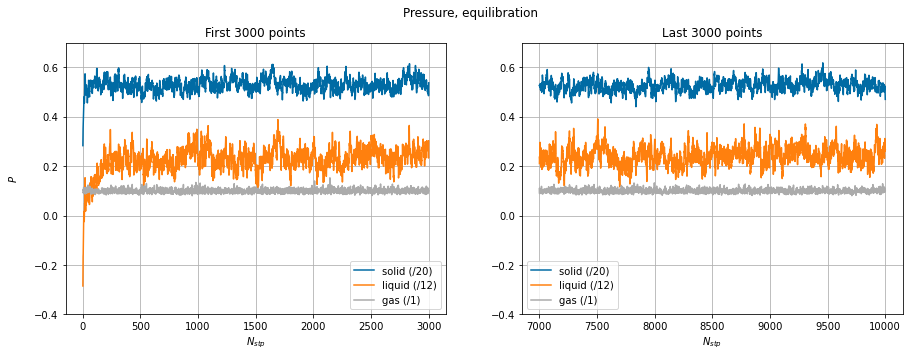

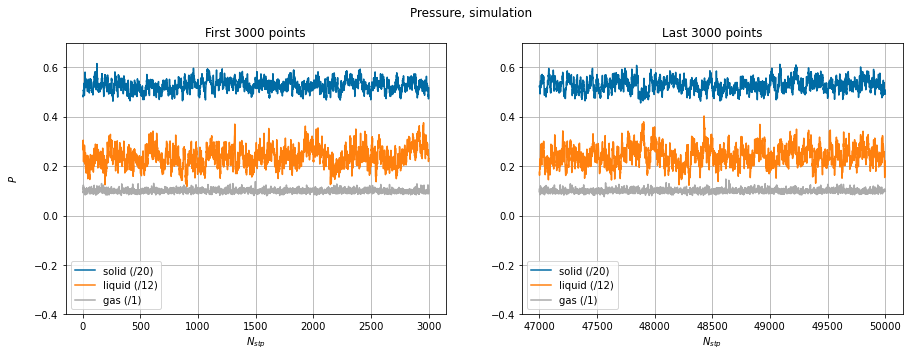

In [4]:
graph_burn("pres",True)
graph_burn("pres",False)

## Autocorrelation functions

With the results of the simulation we calculate the autocorrelation functions for both energy and pressure. Thanks to these functions we can properly estimate the MC correlation time which is the time interval needed to the system to get from a state to a significantly different (uncorrelated) one. We define such interval as the time scale on which the autocorrelation functions tends to zero; a good estimate of this quantity leads to a better choice for the block size $L$, assuring that we populate each block with uncorrelated entries.

For an observable $X$, the autocorrelation function $Ac(t)$ is defined as:

$$
Ac(t)=\frac{\langle X(t') X(t'+t) \rangle_{t'} - \langle X(t')\rangle_{t'} \langle X(t'+t) \rangle_{t'}}{\sigma_X^2}.
$$

Looking at the graphs we can observe, after a few time steps, each autocorrelation function drops and that for $t \sim 200$ we have uncorrelated entries for each state of matter; so we can safely choose $L = 1000$.

In [5]:
long=500 #t in graph, but I use tmax=20*long to reduce near tmax fluctuations (not all data for efficiency)
t,tmax=np.arange(long),20*long

def autocorr(state,meas):   #state can be "solid","liquid","gas"; meas can be "epot", "pres"
    data=np.genfromtxt('build/ex07.1/'+state+'/results/instant_'+meas+'.dat',max_rows=tmax,usecols=(1))
    summ=[np.zeros(long) for i in range(3)]
    summ[0]=[sum(data[0:tmax-tt]*data[tt:tmax]) for tt in t]
    summ[1]=[sum(data[0:tmax-tt]) for tt in t]
    summ[2]=[sum(data[tt:tmax]) for tt in t]
    for i in range(3): summ[i]/=tmax-t
    a=1./tmax*sum(data**2)-(1./tmax*sum(data))**2
    print("...", end=" ")
    return (summ[0]-summ[1]*summ[2])/a

In [6]:
print("computing energy autocorrelation...", end=" ")
Ac_ene=(autocorr('solid','epot'),autocorr('liquid','epot'),autocorr('gas','epot'))
print(); print("computing pressure autocorrelation...", end=" ")
Ac_pres=(autocorr('solid','pres'),autocorr('liquid','pres'),autocorr('gas','pres'))
Ac=(Ac_ene,Ac_pres)

computing energy autocorrelation... ... ... ... 
computing pressure autocorrelation... ... ... ... 

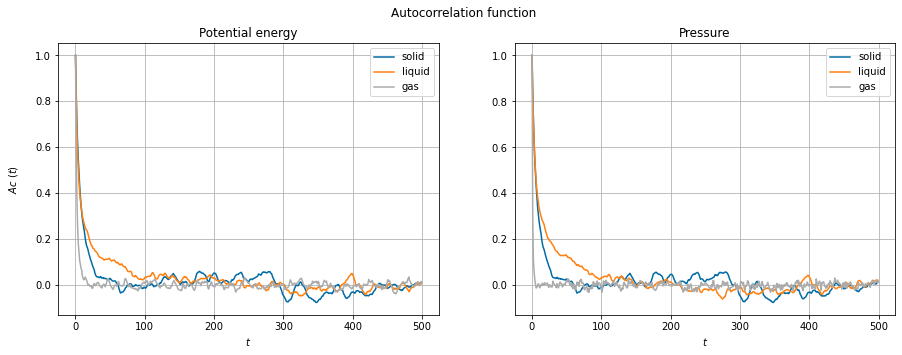

In [7]:
pl.figure(figsize=(15,5))
for i in range(2):
    pl.subplot(1,2,i+1)
    for j in range(3): pl.plot(t,Ac[i][j],label=lab_state[j])
    pl.legend(loc='best')
    pl.xlabel('$t$')
    if i==0: pl.ylabel('$Ac\ (t)$',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('Autocorrelation function')
pl.show()

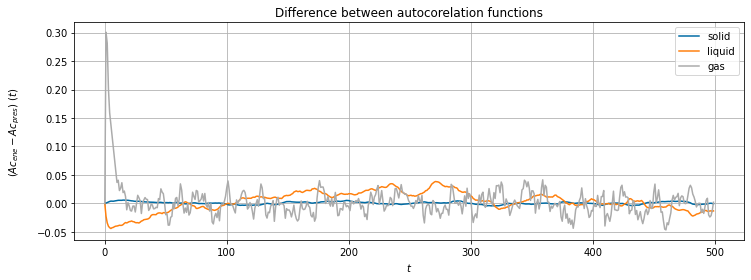

In [8]:
pl.figure(figsize=(12,4))
for j in range(3): pl.plot(t,Ac[0][j]-Ac[1][j],label=lab_state[j])
pl.legend(loc='best')
pl.xlabel('$t$')
pl.ylabel('$(Ac_{ene}-Ac_{pres})\ (t)$',labelpad=15)
pl.title('Difference between autocorelation functions')
pl.grid(True)
pl.show()

## Blocking method uncertainties estimation
To better validate our choice of the block size $L$ we analyze the results of the main simulation to get an estimate of the statistical uncertainties of energy and pressure with the blocking method. 

In the graphs below the uncertainties are plotted as functions of $L$, and we can observe that for small values of $L$ the uncertainties are underestimated: this behavior might be due to the fact that when averaging over small blocks the correlation between them are still very strong. For bigger values of $L$, and around our previous estimate, the uncertainties reach a peak value and sort of stay stable at it (the liquid case being the less stable one): with more measures for a single interval we obtain better block averages but the CLT advantage is weaker, since we are using less blocks. 

From these observations we can safaely choose our previous chose value, $L = 1000$, and so for a simulation of $M=5*10^5$ steps we have $N = 500$ blocks.

In [9]:
def autocorrelation(observable):
    #initialize vector
    auto=np.zeros(len(observable))
    #compute denominator
    tot=np.sum(observable)
    #is it right? t from zero to len-1?
    tmax=len(observable)-1
    #global normalization factor
    norm=np.dot(observable, observable)/tmax-tot*tot/(tmax*tmax)
    cumsum=np.cumsum(observable)
    for i in range( len(observable)-1): #if arrive to len(obs) a division by zero occours
        norm2=tmax-i #normalization factor at the numerator
        a=np.dot(observable[:tmax-i+1], observable[i:])            
        auto[i]=a/norm2-(cumsum[tmax-i]*(tot-cumsum[i]))/(norm2*norm2)
    #arbitrary set correlation a tmax = 0 (auto has been initialized to all zeros, and i am not setting the last
    #component)
    return auto/norm


def last_blocking_error(observable, per_block):
    n_blocks=int(len(observable)/per_block)
    blocks=np.zeros(n_blocks)
    for i in range(n_blocks):
        blocks[i]=np.sum(observable[i*per_block:(i+1)*per_block])
    blocks/=per_block
    blocks2=np.multiply(blocks, blocks)
    
    blocks=np.sum(blocks)
    blocks2=np.sum(blocks2)
    err=np.sqrt((blocks2/n_blocks - np.power(blocks/n_blocks,2))/(n_blocks-1))
        
    return err

In [10]:
def blocking_error(state, meas):
    instant = np.loadtxt('build/ex07.1/'+state+'/results/instant_'+meas+ '.dat',usecols=(1))
    correlation = autocorrelation(instant)
    err=[]
    value=[]
    blk_size=[]
    for i in range (10, 100,10):
        blk_size.append(i)
        err.append(last_blocking_error(instant, i))
    for i in range (50, 5000,50):
        blk_size.append(i)
        err.append(last_blocking_error(instant, i))
    grap=[blk_size, err]
    return grap

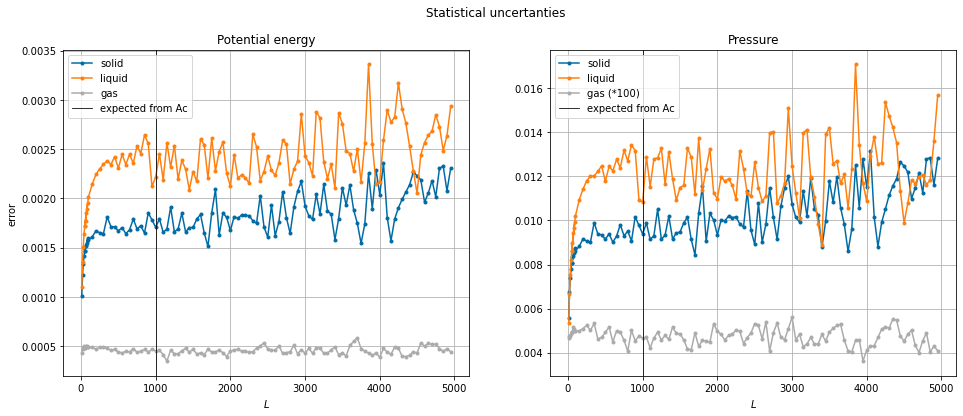

In [11]:
esol = blocking_error('solid', 'epot')
eliq = blocking_error('liquid', 'epot')
egas = blocking_error('gas', 'epot')
psol = blocking_error('solid', 'pres')
pliq = blocking_error('liquid', 'pres')
pgas = blocking_error('gas', 'pres')
pgass = [100*x for x in pgas[1]]

pl.figure(figsize=(16,6))
pl.subplot(1,2,1)
pl.plot(esol[0], esol[1], marker='.', label='solid')
pl.plot(eliq[0], eliq[1], marker='.', label='liquid')
pl.plot(egas[0], egas[1], marker='.', label='gas')
pl.axvline(x=1000,color='k',linewidth=0.8,label='expected from Ac')
pl.grid(True)
pl.ylabel('error')
pl.title('Potential energy')
pl.legend(loc='best')
pl.xlabel('$L$')
pl.subplot(1,2,2)
pl.plot(psol[0], psol[1], marker='.', label='solid')
pl.plot(pliq[0], pliq[1], marker='.', label='liquid')
pl.plot(pgas[0], pgass, marker='.', label='gas (*100)')
pl.axvline(x=1000,color='k',linewidth=0.8,label='expected from Ac')
pl.legend(loc='best')
pl.xlabel('$L$')
pl.grid(True)
pl.title('Pressure')
pl.suptitle('Statistical uncertanties', )
pl.show()

# Exercise 07.2
## Radial distribution function in MCMD code

As previously mentioned, we estimate the radial distribution function $g(r)$ and the energy and pressure average values for each state of matter using the blocking method, with $N=500$ blocks and $L=1000$ entries per block. 

After an equilibration phase of $3000$ steps, the simulation starts, and the $g(r)$ estimation is obtained filling an histogram, whereas the quantities estimations are obtained as usual.

The first two graphs shows the radial distribution function, the first depicting it as a function of $r$ (in Lennard-Jones units) and the second one in terms of each values per bin, for a total of 100 bins. 
We observe how the three different state of matter leads to diffent behaviors of $g(r)$ (the difference of the domain is due to the different sizes of the box in each simulation). For small $r$, each $g(r)$ is almost zero, because of the strong inter-particle repulsive potential. As $r$ grows, each distribution oscillates differently, and in the liquid and gas phase it saturates to $1$, which is expected because the potential goes to zero and the particles are more and more similar to an ideal gas. This also happens, though in minor way, in the solid case.

Finally, we also plot the results for energy and pressure, in each state, converted in SI units to describe a system of interacting **Argon** atoms.

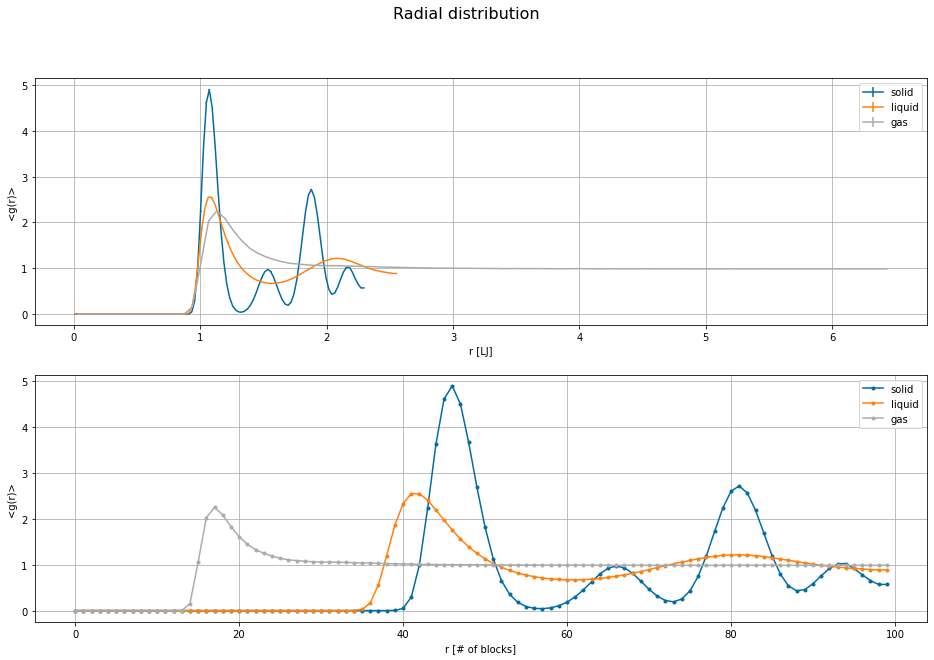

In [12]:
pl.figure(figsize=(16,10))

for k in range (2):
    pl.subplot(2,1,k+1) 
    for state in lab_state:
        g = np.loadtxt('build/ex07.2/'+ state + '/results/gave.dat')
        r = np.loadtxt('build/ex07.2/' + state + '/results/binning.dat')
        g_err = np.loadtxt('build/ex07.2/' + state + '/results/gerr.dat')    
        if k==0: 
            pl.errorbar(r[-1],g[-1],yerr=g_err[-1], label=state)
            pl.xlabel("r [LJ]")
        else: 
            pl.plot(g[-1], label=state, marker='.')
            pl.xlabel("r [# of blocks]")

    pl.legend(loc='best')
    pl.grid(True)
    pl.ylabel("<g(r)>")
pl.suptitle("Radial distribution", size='16')
pl.show()

In [13]:
#costants for conversion between LJ units and SI units
sig=0.34                            #sigma [nm]
kB,eps_kB=1.98064852e-23,120.       #Boltzmann constant [J/K], eps/kB [K]
eps=eps_kB*kB;                      #eps [J]

EpotS=np.genfromtxt('build/ex07.2/solid/results/epot.dat',usecols=(0,2,3),names='nblk,res,err')
EpotL=np.genfromtxt('build/ex07.2/liquid/results/epot.dat',usecols=(0,2,3),names='nblk,res,err')
EpotG=np.genfromtxt('build/ex07.2/gas/results/epot.dat',usecols=(0,2,3),names='nblk,res,err')
PS=np.genfromtxt('build/ex07.2/solid/results/pres.dat',usecols=(0,2,3),names='nblk,res,err')
PL=np.genfromtxt('build/ex07.2/liquid/results/pres.dat',usecols=(0,2,3),names='nblk,res,err')
PG=np.genfromtxt('build/ex07.2/gas/results/pres.dat',usecols=(0,2,3),names='nblk,res,err')
obs=(EpotS,PS,EpotL,PL,EpotG,PG)

for i in range(6):
    obs[i]['res']*=eps; obs[i]['err']*=eps    #energy conversion
    if i%2==1: obs[i]['res']*=1e18/(sig**3); obs[i]['err']*=1e18/(sig**3) #pressure conversion


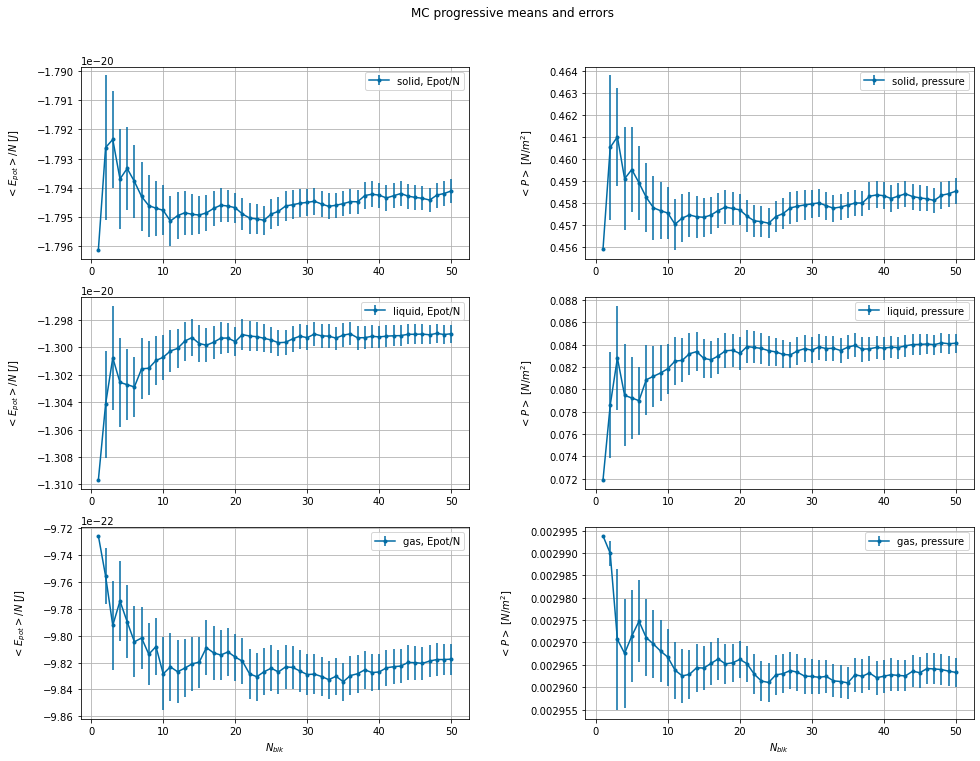

In [14]:
obs_label=(', Epot/N',', pressure'); y_lab=['$<E_{pot}>/N\ [J]$','$<P>\ [N/m^2]$']

pl.figure(figsize=(16,12))
for i in range(6):
    pl.subplot(3,2,i+1)
    pl.errorbar(obs[i]['nblk'],obs[i]['res'],yerr=obs[i]['err'],marker='.',label=lab_state[i//2]+obs_label[i%2])
    pl.legend(loc='best')
    if i>3: pl.xlabel('$N_{blk}$')
    pl.ylabel(y_lab[i%2],labelpad=15)
    pl.grid(True)
pl.suptitle("MC progressive means and errors", y=0.95)
pl.subplots_adjust(wspace=0.3)
pl.show()

# Exercise 07.3
## Radial distribution function in the MD code

In this exercise we compute the radial distribution function $g(r)$ using the Verlet algorithm, implemented in MD code used in exercise 4. 

The simulation parameters are the same as the one of exercise 4.

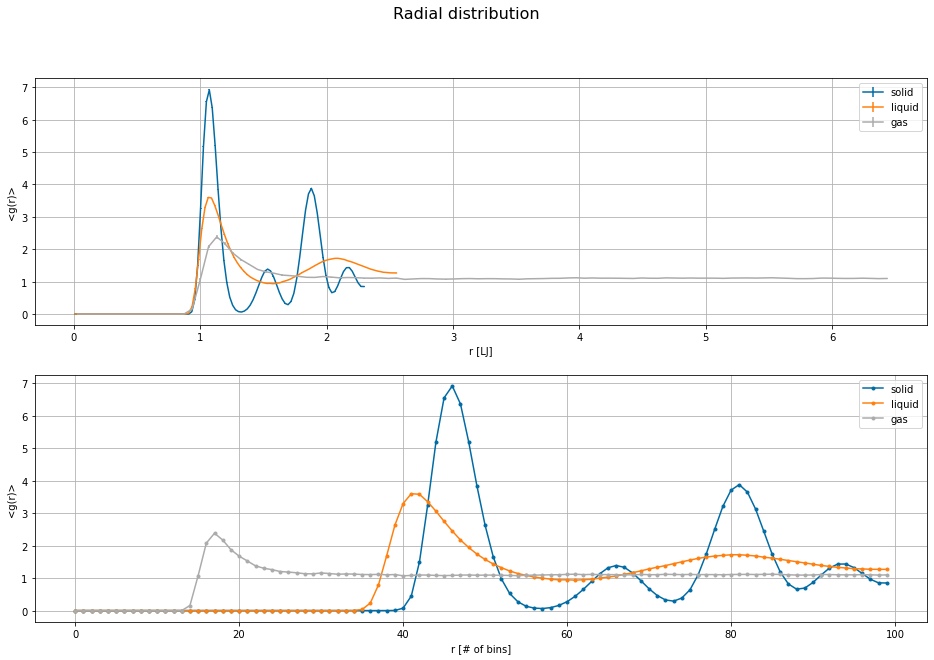

In [20]:
pl.figure(figsize=(16,10))
lab_state=['solid','liquid','gas'];

for k in range (2):
    pl.subplot(2,1,k+1) 
    for state in lab_state:
        g = np.loadtxt('build/ex07.3/'+ state + '/results/gave.dat')
        r = np.loadtxt('build/ex07.3/' + state + '/results/binning.dat')
        g_err = np.loadtxt('build/ex07.3/' + state + '/results/gerr.dat')    
        if k==0: 
            pl.errorbar(r[-1],g[-1],yerr=g_err[-1], label=state)
            pl.xlabel("r [LJ]")
        else: 
            pl.plot(g[-1], label=state, marker='.')
            pl.xlabel("r [# of bins]")

    pl.legend(loc='best')
    pl.grid(True)
    pl.ylabel("<g(r)>")
pl.suptitle("Radial distribution", size='16')
pl.show()

# Exercise 07.4

Here we compare the results obtained with the two methods. There is very little different between the two, but the "form" of the function it's the same, so it's safe to say that they are in accordance, 

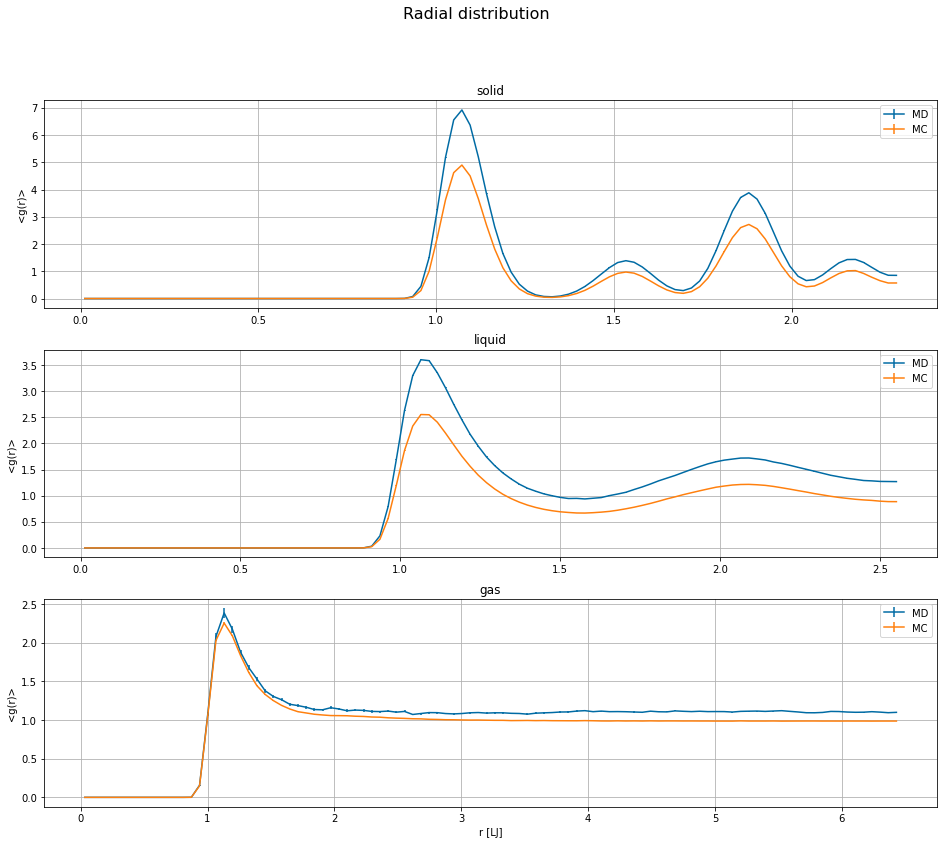

In [22]:
pl.figure(figsize=(16,13))
state = ('solid', 'liquid', 'gas')
for k in range (3):
    pl.subplot(3,1,k+1) 
    gMD = np.loadtxt('build/ex07.3/'+ state[k] + '/results/gave.dat')
    gMC = np.loadtxt('build/ex07.2/'+ state[k] + '/results/gave.dat')
    r = np.loadtxt('build/ex07.3/' + state[k] + '/results/binning.dat')
    gMD_err = np.loadtxt('build/ex07.3/' + state[k] + '/results/gerr.dat')
    gMC_err = np.loadtxt('build/ex07.2/' + state[k] + '/results/gerr.dat')    
    pl.errorbar(r[-1],gMD[-1],yerr=gMD_err[-1], label='MD')
    pl.errorbar(r[-1],gMC[-1],yerr=gMC_err[-1], label='MC')
    if k==2 : pl.xlabel("r [LJ]") 
    pl.title(state[k])
    pl.legend(loc='best')
    pl.grid(True)
    pl.ylabel("<g(r)>")
pl.suptitle("Radial distribution", size='16')
pl.show()